# Preâmbulo

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats import ks_2samp, spearmanr
# import dataframe_image as dfi
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
sns.set_theme(style="darkgrid")
from scipy.linalg import toeplitz
from matplotlib import pyplot as plt

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [4]:
# Parâmetros
dict_meses = {1: "Janeiro", 2: "Fevereiro", 3: "Março", 4: "Abril", 5: "Maio",
              6: "Junho", 7: "Julho", 8: "Agosto", 9: "Setembro",
              10: "Outubro", 11: "Novembro", 12: "Dezembro"}

In [5]:
# Funções
def highlight_cells(val: float):
    '''Personalização do display dos dataframes de teste de hipóteses'''
    if val < 0.05:
        color = '#d14133'
    elif val == 1:
        color = '#636363'
    elif val > 0.05:
        color = '#399234'
    else:
        color = ''
    return 'background-color: {}'.format(color)


def matrix_spearman_test(columns: list, df: pd.DataFrame) -> pd.DataFrame:
      '''Apresenta matriz de p-values de teste de correlação de Spearman 
      para as colunas selecionadas'''
      index = columns.copy()
      data_frame = pd.DataFrame(index=index, columns=columns)
      for i in columns:
          for j in index:
              stat, p = spearmanr(df[i], df[j])
              data_frame[i][j] = p
      return data_frame


def matrix_ks_2samp_test_months(random_var: str, df: pd.DataFrame, meses: dict = dict_meses) -> pd.DataFrame:
    '''Apresenta matriz de p-values de teste de Kolmogorov-Smirnov em pares
    para uma dada variável aleatória de acordo com o mês'''
    columns = [n for n in range(1, 13)]
    index = columns.copy()
    data_frame = pd.DataFrame(index=index, columns=columns)
    for i in columns:
        for j in index:
            stat, p = ks_2samp(df.loc[df["date"].dt.month==i][random_var], 
                              df.loc[df["date"].dt.month==j][random_var])
            data_frame[i][j] = p
    data_frame = data_frame.rename(columns=meses, index=meses)
    return data_frame


def matrix_ks_2samp_test_types(random_var: str, df: pd.DataFrame, meses: dict = dict_meses) -> pd.DataFrame:
    '''Apresenta matriz de p-values de teste de Kolmogorov-Smirnov em pares
    para uma dada variável aleatória de acordo com o tipo de ligação'''
    columns = [n for n in range(3)]
    index = columns.copy()
    data_frame = pd.DataFrame(index=index, columns=columns)
    for i in columns:
        for j in index:
            stat, p = ks_2samp(df.loc[df["call_type"]==i][random_var], 
                              df.loc[df["call_type"]==j][random_var])
            data_frame[i][j] = p
    data_frame = data_frame.rename(columns={0: "Call_type 0", 1: "Call_type 1", 2: "Call_type 2"}, 
                       index={0: "Call_type 0", 1: "Call_type 1", 2: "Call_type 2"})
    return data_frame


def matrix_ks_2samp_test_weeks(random_var: str, df: pd.DataFrame, semanas: list) -> pd.DataFrame:
    '''Apresenta matriz de p-values de teste de Kolmogorov-Smirnov em pares
    para uma dada variável aleatória de acordo com a semana do ano'''
    columns = semanas
    index = columns.copy()
    data_frame = pd.DataFrame(index=index, columns=columns)
    for i in columns:
        for j in index:
            stat, p = ks_2samp(df.loc[df["date"].dt.isocalendar().week == i][random_var], 
                               df.loc[df["date"].dt.isocalendar().week == j][random_var])
            data_frame[i][j] = p
    return data_frame


def resumo_call_type(df, tipo):
    '''Apresenta um breve resumo do call type desejado, contendo número de chamadas atendidas,
    número de falhas e percentual de falhas'''
    df = df.loc[df["call_type"] == tipo]
    # Número de chamadas analisadas
    n = len(df)
    print(f"Ligações do tipo {tipo} atendidas em 2021:", n)

    # Chamadas que demoraram mais de um minuto para serem atendidas
    falhas = df.loc[df["wait_length"] > 60]
    qtd_falhas = len(falhas) 
    print("Ligações que demoraram mais de 60 segundos para atendimento:", qtd_falhas)

    # Percentual anual de falhas
    print(f"No ano de 2021, em média, {(qtd_falhas / n) * 100 :.2f}% das ligações do tipo {tipo} demoraram mais de 60 segundos para serem atendidas")

# Base de dados das ligações

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/calls.csv")
# Conversão do time stamp da data
df["date"] = pd.to_datetime(df.date, format="%d/%m/%Y")
df["call_started"] = pd.to_datetime(df.call_started, format="%I:%M:%S %p")
df.head()

,call_id,date,daily_caller,call_started,call_answered,call_ended,wait_length,service_length,meets_standard,call_type
0,1,2021-01-01,1,1900-01-01 08:00:00,8:00:00 AM,8:14:22 AM,0,863,True,1
1,2,2021-01-01,2,1900-01-01 08:02:42,8:02:42 AM,8:07:31 AM,0,289,True,0
2,3,2021-01-01,3,1900-01-01 08:08:24,8:08:24 AM,8:10:13 AM,0,108,True,1
3,4,2021-01-01,4,1900-01-01 08:09:37,8:09:37 AM,8:13:45 AM,0,247,True,1
4,5,2021-01-01,5,1900-01-01 08:11:10,8:11:10 AM,8:15:28 AM,0,258,True,1


O gerente deseja que 90% das chamadas sejam atendidas em até um minuto, as unidades de tempo da base de dados estão em segundos

## Análise anual

In [7]:
# Número de chamadas analisadas
n = len(df)  # 51708

# Chamadas que demoraram mais de um minuto para serem atendidas
falhas = df.loc[df["meets_standard"] == False]
qtd_falhas = len(falhas)  # 4227

# Percentual anual de falhas
print(f"No ano de 2021, em média, {(qtd_falhas / n) * 100 :.2f}% das ligações demoraram mais de 60 segundos para serem atendidas")

No ano de 2021, em média, 8.17% das ligações demoraram mais de 60 segundos para serem atendidas


### Distribuição de ligações por dia do ano

In [8]:
# Quantidade de dias comerciais registrados
len(df["date"].unique())

261

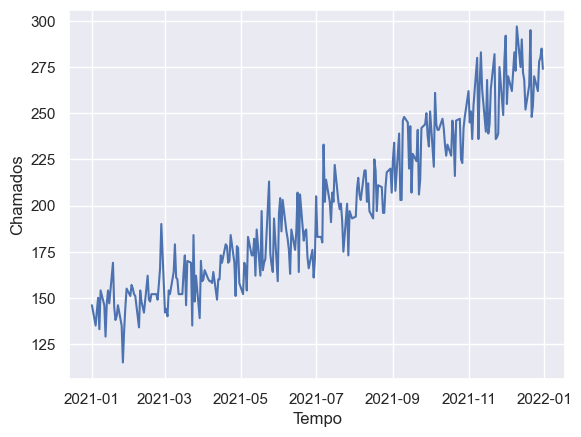

In [9]:
# Agrupando ligações por dia
ligacoes = df.groupby(["date"])["daily_caller"].max()
ligacoes.head()
# Mostra a tendência de ligações por dia ao longo do ano
sns.lineplot(data=ligacoes).set(xlabel="Tempo", ylabel="Chamados");

Há uma tendência linear de crescimento do número de ligações recebidas por dia ao longo do ano

### Análise e descrição dos tempos de serviço e de espera

In [10]:
a = df["service_length"].describe()
print(a.to_latex(index=True)) 

\begin{tabular}{lr}
\toprule
{} &  service\_length \\
\midrule
count &     51708.000   \\
mean  &       299.103   \\
std   &       299.866   \\
min   &         0.000   \\
25\%   &        86.000   \\
50\%   &       208.000   \\
75\%   &       414.000   \\
max   &      3110.000   \\
\bottomrule
\end{tabular}



C:\Users\Lucas\AppData\Local\Temp\ipykernel_10364\3386321473.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(a.to_latex(index=True))


In [11]:
# Tempo de espera
print("Descrição do Tempo de Espera: \n",df["wait_length"].describe().to_string(),
      "\n","-"*100)
# Tempo de serviço
print("\nDescrição do Tempo de Serviço: \n",df["service_length"].describe().to_string(),
      "\n","-"*100)

Descrição do Tempo de Espera: 
 count    51708.000
mean        17.035
std         64.061
min          0.000
25%          0.000
50%          0.000
75%          0.000
max        983.000 
 ----------------------------------------------------------------------------------------------------

Descrição do Tempo de Serviço: 
 count    51708.000
mean       299.103
std        299.866
min          0.000
25%         86.000
50%        208.000
75%        414.000
max       3110.000 
 ----------------------------------------------------------------------------------------------------


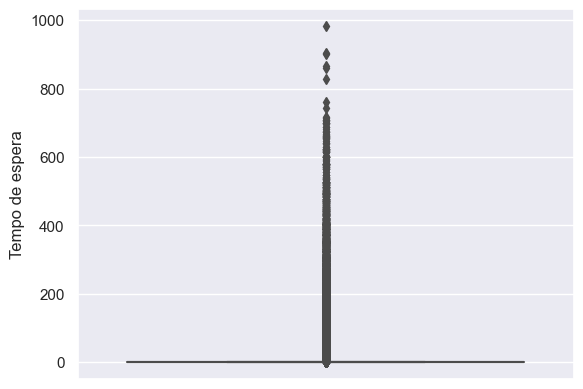

In [12]:
# Boxplot tempo de espera
sns.boxplot(y="wait_length", data=df).set(ylabel="Tempo de espera");

Há muitos outliers pois mais de 75% dos valores de tempo de espera são nulos, é melhor, portanto, não retirá-los

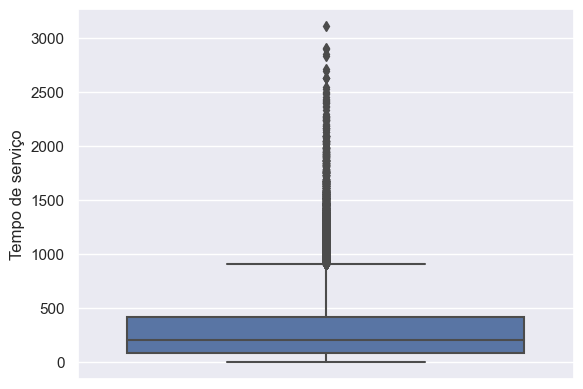

In [51]:
# Boxplot tempo de serviço
sns.boxplot(y="service_length", data=df).set(ylabel="Tempo de serviço");

Há também alguns outliers na análise do tempo de serviço que não julgamos necessário retirar, pois é interessante modelar essa variável aleatória com uma distribuição que leve em consideração a presença de valores extremos

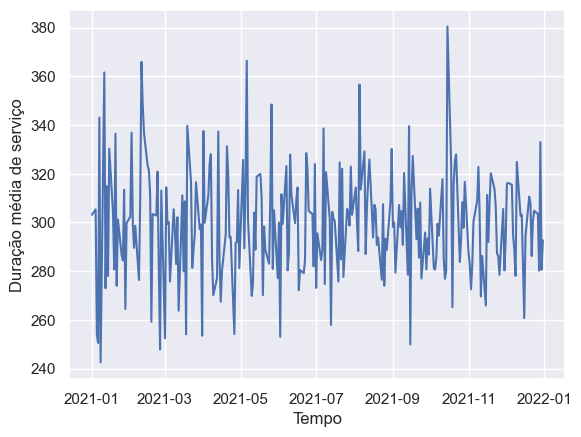

In [52]:
# Comportamento do tempo médio de serviço ao longo do ano
t_servico = df.groupby(["date"])["service_length"].mean()
# Gráfico de linha do tempo de serviço médio ao longo do ano
sns.lineplot(data=t_servico).set(xlabel="Tempo", ylabel="Duração média de serviço");

O tempo de serviço é aparentemente constante ao longo do ano, variando entre 4 e 6 minutos por ligação

Para testar nossas hipóteses utilizaremos o teste de Kolmogorov-Smirnov com 2 amostras. Esse teste é não paramétrico, isto é, não depende da distribuição das variáveis analisadas e testa a hipótese de que as duas amostras seguem uma mesma distribuição da seguinte forma:

$H_0:$ Ambas as amostras seguem uma mesma distribuição de probabilidade

$H_a:$ As amostras não seguem uma mesma distribuição de probabilidade

Portanto, definimos um nível de significância $\alpha = 0,05$ e analisamos os valores $p$ obtidos

In [15]:
testes = matrix_ks_2samp_test_months(random_var="service_length", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para tempo de serviço entre meses")

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
Janeiro,1.000000,0.539682,0.812293,0.256586,0.686531,0.213343,0.901055,0.501365,0.646593,0.455533,0.851607,0.244136
Fevereiro,0.539682,1.000000,0.166747,0.567613,0.521534,0.597656,0.501749,0.712118,0.626175,0.414783,0.134640,0.781156
Março,0.812293,0.166747,1.000000,0.556098,0.532970,0.227363,0.807715,0.514176,0.637592,0.571722,0.999157,0.438829
Abril,0.256586,0.567613,0.556098,1.000000,0.285730,0.607213,0.124089,0.972075,0.619759,0.352190,0.585494,0.898245
Maio,0.686531,0.521534,0.532970,0.285730,1.000000,0.964981,0.942911,0.610175,0.645276,0.899609,0.474400,0.518063
Junho,0.213343,0.597656,0.227363,0.607213,0.964981,1.000000,0.609780,0.862771,0.907490,0.578312,0.256022,0.947341
Julho,0.901055,0.501749,0.807715,0.124089,0.942911,0.609780,1.000000,0.515389,0.954315,0.660659,0.748578,0.587768
Agosto,0.501365,0.712118,0.514176,0.972075,0.610175,0.862771,0.515389,1.000000,0.849642,0.875283,0.379730,0.900799
Setembro,0.646593,0.626175,0.637592,0.619759,0.645276,0.907490,0.954315,0.849642,1.000000,0.735153,0.539403,0.691972
Outubro,0.455533,0.414783,0.571722,0.352190,0.899609,0.578312,0.660659,0.875283,0.735153,1.000000,0.456450,0.889161


O teste não paramétrico de Kolmogorov-Smirnov confirma que não há diferenças estatísticas significativas ($\alpha=0,05$) entre tempos de serviço ao longo do ano, avaliando em base mensal 

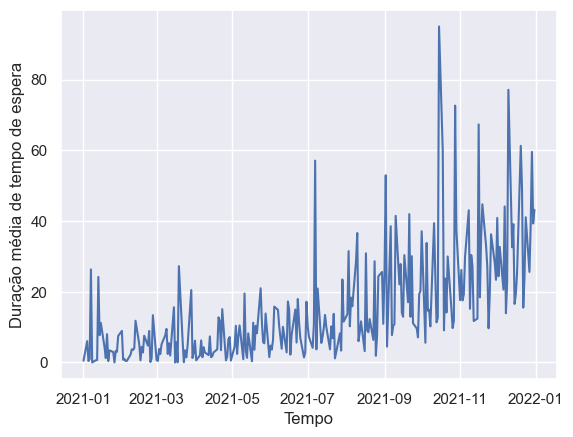

In [53]:
# Comportamento do tempo médio de espera ao longo do ano
t_espera = df.groupby(["date"])["wait_length"].mean()
# Gráfico de linha do espera médio ao longo do ano
sns.lineplot(data=t_espera).set(xlabel="Tempo", ylabel="Duração média de tempo de espera");

In [17]:
testes = matrix_ks_2samp_test_months(random_var="wait_length", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para tempo de espera entre meses")

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
Janeiro,1.000000,0.999994,0.987253,0.874800,0.068770,0.006124,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000
Fevereiro,0.999994,1.000000,1.000000,0.999986,0.251817,0.039507,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000
Março,0.987253,1.000000,1.000000,1.000000,0.336895,0.064457,0.000031,0.000000,0.000000,0.000000,0.000000,0.000000
Abril,0.874800,0.999986,1.000000,1.000000,0.569863,0.134464,0.000120,0.000000,0.000000,0.000000,0.000000,0.000000
Maio,0.068770,0.251817,0.336895,0.569863,1.000000,0.997352,0.034338,0.000006,0.000000,0.000000,0.000000,0.000000
Junho,0.006124,0.039507,0.064457,0.134464,0.997352,1.000000,0.204852,0.000097,0.000000,0.000000,0.000000,0.000000
Julho,0.000001,0.000020,0.000031,0.000120,0.034338,0.204852,1.000000,0.117362,0.000018,0.000000,0.000000,0.000000
Agosto,0.000000,0.000000,0.000000,0.000000,0.000006,0.000097,0.117362,1.000000,0.079798,0.000014,0.000000,0.000000
Setembro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000018,0.079798,1.000000,0.072091,0.000001,0.000000
Outubro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000014,0.072091,1.000000,0.031059,0.000000


O teste mostra que os tempos de espera até abril seguem uma mesma distribuição, mas a partir de maio, vemos que o p-value de 0.069 já indica maiores diferenças entre os tempos de espera dos meses de janeiro e maio

### Fit dos tempos de serviço

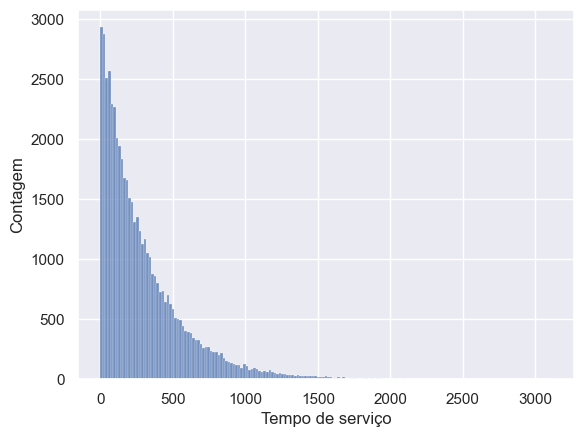

In [54]:
# Histograma dos tempos de serviço
sns.histplot(data=df, x="service_length").set(xlabel="Tempo de serviço", ylabel="Contagem");

O histograma com os valores de tempos de serviço apresenta comportamento similar ao de uma distribuição exponencial

Fitting 10 distributions: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,3.229e-08,2183.934,-1.453e+06,inf,0.003,7.734e-01
chi2,3.316e-08,2184.920,-1.452e+06,inf,0.007,2.258e-02
gamma,3.362e-08,2185.605,-1.451e+06,inf,0.007,1.550e-02
exponpow,1.258e-06,2611.983,-1.264e+06,inf,0.050,9.426e-112
cauchy,1.140e-05,2040.311,-1.150e+06,inf,0.198,0.000e+00


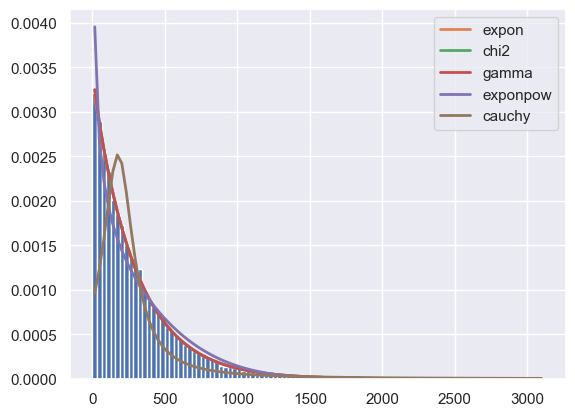

In [19]:
tempos_servico = df["service_length"].values
f = Fitter(tempos_servico, distributions=get_common_distributions())
f.fit()
f.summary()

A distribuição exponencial é a candidata mais adequada para modelar o tempo de serviço

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,3.229e-08,2183.934,-1.453e+06,inf,0.003,0.773


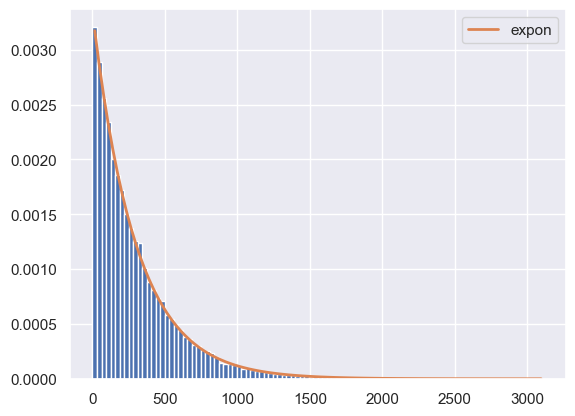

In [20]:
f = Fitter(tempos_servico, distributions="expon")
f.fit()
f.summary()

In [21]:
# Melhor fit para tempos de serviço é exponencial
f.get_best(method = 'sumsquare_error')

{'expon': {'loc': 0.0, 'scale': 299.1025953430804}}

O tempo de serviço pode ser modelado por uma exponencial de média $299.10$

### Análise dos tempos entre chegadas das ligações

Avaliaremos o tempo de chegada a partir da diferença entre a chegada das chamadas em um dia

In [22]:
df["arrival_time_diff"] = df["call_started"].diff().dt.total_seconds()
# Substitui os valores inadequados por 0
df.loc[df["arrival_time_diff"] < 0, "arrival_time_diff"] = 0
df = df.fillna(0)
df.head()

,call_id,date,daily_caller,call_started,call_answered,call_ended,wait_length,service_length,meets_standard,call_type,arrival_time_diff
0,1,2021-01-01,1,1900-01-01 08:00:00,8:00:00 AM,8:14:22 AM,0,863,True,1,0.0
1,2,2021-01-01,2,1900-01-01 08:02:42,8:02:42 AM,8:07:31 AM,0,289,True,0,162.0
2,3,2021-01-01,3,1900-01-01 08:08:24,8:08:24 AM,8:10:13 AM,0,108,True,1,342.0
3,4,2021-01-01,4,1900-01-01 08:09:37,8:09:37 AM,8:13:45 AM,0,247,True,1,73.0
4,5,2021-01-01,5,1900-01-01 08:11:10,8:11:10 AM,8:15:28 AM,0,258,True,1,93.0


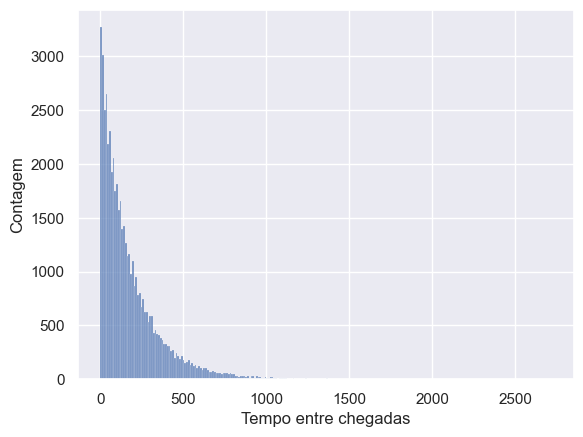

In [55]:
# Histograma dos intervalos de chegada
sns.histplot(data=df, x="arrival_time_diff").set(xlabel="Tempo entre chegadas", ylabel="Contagem");

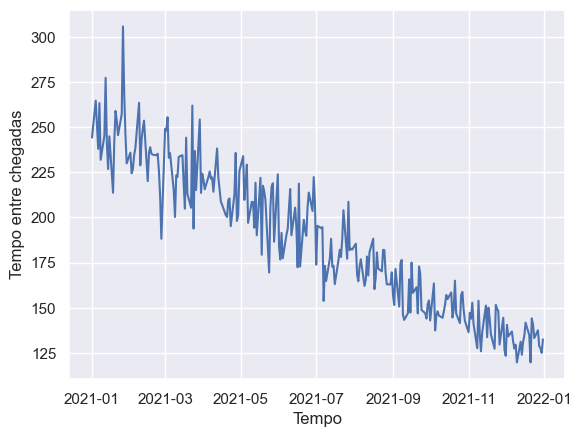

In [56]:
# Agrupando time_diff por dia e obtendo a média
chegadas = df.groupby(["date"])["arrival_time_diff"].mean()
# Mostra a tendência de tempo de chegada de ligações por dia ao longo do ano
sns.lineplot(data=chegadas).set(xlabel="Tempo", ylabel="Tempo entre chegadas");

Há uma tendência linear de queda do tempo médio entre as chegadas ao longo do ano, isso está de acordo com a constatação de que o número de chamadas recebidas aumenta linearmente ao longo do ano

In [25]:
testes = matrix_ks_2samp_test_months(random_var="arrival_time_diff", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para intervalo de chegadas em base mensal")

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
Janeiro,1.000000,0.044309,0.001751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fevereiro,0.044309,1.000000,0.050702,0.016655,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Março,0.001751,0.050702,1.000000,0.143584,0.005403,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Abril,0.000000,0.016655,0.143584,1.000000,0.063691,0.002019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Maio,0.000000,0.000006,0.005403,0.063691,1.000000,0.031724,0.000034,0.000000,0.000000,0.000000,0.000000,0.000000
Junho,0.000000,0.000000,0.000011,0.002019,0.031724,1.000000,0.003164,0.000012,0.000000,0.000000,0.000000,0.000000
Julho,0.000000,0.000000,0.000000,0.000000,0.000034,0.003164,1.000000,0.238733,0.000005,0.000000,0.000000,0.000000
Agosto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000012,0.238733,1.000000,0.004325,0.000000,0.000000,0.000000
Setembro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000005,0.004325,1.000000,0.016511,0.000001,0.000000
Outubro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016511,1.000000,0.011048,0.000011


É interessante notar que mesmo para meses subsequentes, o teste de Kolgomogorov-Smirnov rejeita a hipótese de que a distribuição dos tempos de chegada entre eles seja idêntica. Isso indica que não é viável agregar períodos maiores que um mês para modelagem das chegadas. Os valores em vermelho são aqueles nos quais o teste rejeitou a hipótese nula, e, portanto, há diferenças significativas de distribuições de probabilidade entre os meses

In [26]:
print(df["arrival_time_diff"].describe().to_string())

count    51708.000
mean       179.668
std        188.007
min          0.000
25%         49.000
50%        121.000
75%        246.000
max       2718.000


Fitting 10 distributions: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
chi2,5.346e-08,2563.891,-1.427e+06,inf,0.014,7.027e-09
expon,1.819e-07,2555.015,-1.364e+06,inf,0.013,3.530e-08
gamma,3.277e-06,2773.384,-1.214e+06,inf,0.086,0.000e+00
exponpow,4.779e-06,3274.372,-1.195e+06,inf,0.113,0.000e+00
cauchy,2.202e-05,2100.783,-1.116e+06,inf,0.201,0.000e+00


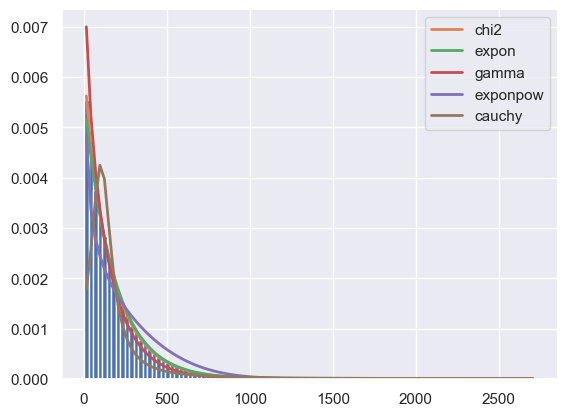

In [27]:
arrival_times = df["arrival_time_diff"].values
f = Fitter(arrival_times, distributions=get_common_distributions())
f.fit()
f.summary()

In [28]:
# Fit exponencial para tempos entre chegadas
f.fitted_param['expon']

(0.0, 179.66765297439468)

O fit para o ano todo não modela tão bem o problema, visto que os tempos de chegada das chamadas variam ao longo do ano, e tais distribuições avaliadas não levam em conta o parâmetro do tempo

Teste de correlação entre os tempos estudados utilizando a correlação de Spearman

In [29]:
df[["wait_length", "service_length", "arrival_time_diff"]].corr(method="spearman")

,wait_length,service_length,arrival_time_diff
wait_length,1.000,3.741e-03,-2.622e-01
service_length,0.004,1.000e+00,-5.214e-04
arrival_time_diff,-0.262,-5.214e-04,1.000e+00


In [30]:
testes = matrix_spearman_test(columns=["wait_length", "service_length", "arrival_time_diff"], df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de correlação de Spearman para as variáveis aleatórias estudadas")

,wait_length,service_length,arrival_time_diff
wait_length,0.000000,0.394934,0.000000
service_length,0.394934,0.000000,0.905620
arrival_time_diff,0.000000,0.905620,0.000000


Portanto, temos correlação entre wait_length e arrival_time_diff, confirmando a hipótese que o tempo de espera depende do intervalo entre chegadas

### Análise por call types

É interessante analisar o comportamento de nossas variáveis aleatórias com relação ao tipo de ligação realizada. Há alguma diferença significativa entre os tipos 0, 1 e 2?

Colocar tabela de resumo dos tipos, com percentual de falhas, número de ligações, etc

In [31]:
resumo_call_type(df, 0)

Ligações do tipo 0 atendidas em 2021: 12830
Ligações que demoraram mais de 60 segundos para atendimento: 1069
No ano de 2021, em média, 8.33% das ligações do tipo 0 demoraram mais de 60 segundos para serem atendidas


In [32]:
resumo_call_type(df, 1)

Ligações do tipo 1 atendidas em 2021: 25792
Ligações que demoraram mais de 60 segundos para atendimento: 2100
No ano de 2021, em média, 8.14% das ligações do tipo 1 demoraram mais de 60 segundos para serem atendidas


In [33]:
resumo_call_type(df, 2)

Ligações do tipo 2 atendidas em 2021: 13086
Ligações que demoraram mais de 60 segundos para atendimento: 1058
No ano de 2021, em média, 8.08% das ligações do tipo 2 demoraram mais de 60 segundos para serem atendidas


#### Teste não paramétrico para testar se os tempos de interesse são iguais para todos os tipos de ligação

In [34]:
testes = matrix_ks_2samp_test_types(random_var="service_length", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para duração de serviço")

,Call_type 0,Call_type 1,Call_type 2
Call_type 0,1.000000,0.624788,0.441323
Call_type 1,0.624788,1.000000,0.771999
Call_type 2,0.441323,0.771999,1.000000


In [35]:
testes = matrix_ks_2samp_test_types(random_var="arrival_time_diff", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para intervalos de chegadas")

,Call_type 0,Call_type 1,Call_type 2
Call_type 0,1.000000,0.985760,0.999016
Call_type 1,0.985760,1.000000,0.994172
Call_type 2,0.999016,0.994172,1.000000


In [36]:
testes = matrix_ks_2samp_test_types(random_var="wait_length", df=df)
testes.style.applymap(highlight_cells).set_caption("p-values do teste de Kolmogorov-Smirnov para tempos de espera")

,Call_type 0,Call_type 1,Call_type 2
Call_type 0,1.000000,0.968333,0.999602
Call_type 1,0.968333,1.000000,1.000000
Call_type 2,0.999602,1.000000,1.000000


In [37]:
# Visualização mês a mês
# for i in range(1, 13):
#     print(f"\nMês {i}")
#     testes = matrix_ks_2samp_test_types(random_var="wait_length", df=df.loc[df['date'].dt.month==i])
#     display(testes.style.applymap(highlight_cells))

Não há diferença estatística entre as distribuições dos tempos de chegada, de serviço e de espera de acordo com o tipo de ligação em base anual

## Análise mensal

### Tabela resumo das médias dos tempos de espera, serviço e de chegada de ligações mês a mês

In [38]:
data = {'mes': ["Janeiro", "Fevereiro", "Março", "Abril", "Maio",
                "Junho", "Julho", "Agosto", "Setembro",
                "Outubro", "Novembro", "Dezembro"],
        'mean_wait_length': [df.loc[df['date'].dt.month==n]["wait_length"].mean() for n in range(1, 13)],
        'mean_service_length': [df.loc[df['date'].dt.month==n]["service_length"].mean() for n in range(1, 13)],
        'mean_arrival_time_diff': [df.loc[df['date'].dt.month==n]["arrival_time_diff"].mean() for n in range(1, 13)],
        'mean_daily_calls': [df.loc[df['date'].dt.month==n].groupby(["date"])["daily_caller"].max().mean() for n in range (1,13)],
        '%_failure': [len(df.loc[df['date'].dt.month==n].loc[df["meets_standard"] == False]) /
                            len(df.loc[df['date'].dt.month==n]) * 100 for n in range(1, 13)]}

resumo = pd.DataFrame(data)
resumo.style.set_caption("Tabela de resumo das médias dos tempos de espera, serviço e de chegada de ligações mês a mês ")

,mes,mean_wait_length,mean_service_length,mean_arrival_time_diff,mean_daily_calls,%_failure
0,Janeiro,5.375000,295.091333,248.624000,143.047619,2.533333
1,Fevereiro,4.363280,307.153545,231.885332,153.300000,2.482849
2,Março,5.659839,293.362026,226.209798,157.347826,2.767783
3,Abril,4.787479,298.619989,214.172433,165.863636,2.828116
4,Maio,7.984802,301.791379,206.973750,173.190476,4.227687
5,Junho,9.218843,299.669242,195.431206,182.818182,4.985045
6,Julho,11.794931,298.707143,180.276498,197.772727,6.036866
7,Agosto,16.159325,304.865878,171.872452,208.090909,7.911462
8,Setembro,21.536639,296.592991,156.499403,229.090909,10.115492
9,Outubro,27.894146,302.287891,149.751203,238.047619,11.768244


A partir dessa tabela vemos que a média do tempo de espera aumenta mês a mês, a média do tempo de serviço permanece relativamente constante, o tempo entre chegadas diminui e, por isso, o número de ligações aumenta mês a mês.

Portanto, o percentual falhas, aqui definido como o percentual de chamadas que demoram mais de 60 segundos para serem atendidas, aumenta mês a mês, ultrapassando, a partir de setembro de 2021, a tolerância de 10% estipulada pelo gerente

## Análise trimestral

In [39]:
data = {'periodo': [f"Trimestre {n}" for n in range(1, 5)],
        'mean_wait_length': [df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)]
                            ["wait_length"].mean() for t in range(0, 4)],
        'mean_service_length': [df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)]
                               ["service_length"].mean() for t in range(0, 4)],
        'mean_arrival_time_diff': [df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)]
                                  ["arrival_time_diff"].mean() for t in range(0, 4)],
        'mean_daily_calls': [df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)].groupby(["date"])
                            ["daily_caller"].max().mean() for t in range (0, 4)],
        '%_failure': [len(df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)]
                          .loc[df["meets_standard"] == False]) /
                     len(df.loc[(df['date'].dt.month==1+3*t) | (df['date'].dt.month==1+3*t+1) | (df['date'].dt.month==1+3*t+2)]) 
                     * 100 for t in range(0, 4)]}

resumo = pd.DataFrame(data)
resumo.style.set_caption("")

,periodo,mean_wait_length,mean_service_length,mean_arrival_time_diff,mean_daily_calls,%_failure
0,Trimestre 1,5.161257,298.262146,234.956481,151.390625,2.604920
1,Trimestre 2,7.391023,300.011532,205.191520,173.969231,4.045063
2,Trimestre 3,16.738384,299.962801,168.947504,211.651515,8.122083
3,Trimestre 4,30.560169,298.265443,139.674982,256.015152,14.183892


Uma agregação maior do que um mês, como a trimestral, subestima a porcentagem de falhas e pode esconder informações como a falha no mês de setembro, que está no 3º trimestre. Além disso, vimos que não é correto agregar o intervalo de chegadas em períodos maiores que um mês, já que este valor é alterado mensalmente

## Análise semanal

Testes de hipótese para verificar se há diferenças estatisticamente significativas do intervalo de chegada semana a semana

In [40]:
# Mês de janeiro intervalos de chegada
teste = matrix_ks_2samp_test_weeks(random_var="arrival_time_diff", df = df, semanas=[n for n in range(1, 9)])
teste.style.applymap(highlight_cells)

,1,2,3,4,5,6,7,8
1,1.000000,0.895541,0.635506,0.615615,0.497819,0.966903,0.588041,0.093597
2,0.895541,1.000000,0.823594,0.607070,0.351146,0.985249,0.443794,0.121901
3,0.635506,0.823594,1.000000,0.312581,0.381446,0.651136,0.470177,0.241507
4,0.615615,0.607070,0.312581,1.000000,0.057124,0.717159,0.115002,0.033184
5,0.497819,0.351146,0.381446,0.057124,1.000000,0.167075,0.958201,0.147202
6,0.966903,0.985249,0.651136,0.717159,0.167075,1.000000,0.548558,0.056267
7,0.588041,0.443794,0.470177,0.115002,0.958201,0.548558,1.000000,0.161125
8,0.093597,0.121901,0.241507,0.033184,0.147202,0.056267,0.161125,1.000000


In [41]:
# Mês de dezembro intervalos de chegada
teste = matrix_ks_2samp_test_weeks(random_var="arrival_time_diff", df = df, semanas=[n for n in range(45, 53)])
teste.style.applymap(highlight_cells)

,45,46,47,48,49,50,51,52
45,1.000000,0.182244,0.857725,0.320285,0.071961,0.166746,0.320232,0.180710
46,0.182244,1.000000,0.602844,0.125497,0.024914,0.181061,0.093705,0.080147
47,0.857725,0.602844,1.000000,0.139887,0.032820,0.140556,0.142464,0.104228
48,0.320285,0.125497,0.139887,1.000000,0.693380,0.949007,0.956980,0.933944
49,0.071961,0.024914,0.032820,0.693380,1.000000,0.696904,0.776036,0.735916
50,0.166746,0.181061,0.140556,0.949007,0.696904,1.000000,0.920658,0.793146
51,0.320232,0.093705,0.142464,0.956980,0.776036,0.920658,1.000000,0.661372
52,0.180710,0.080147,0.104228,0.933944,0.735916,0.793146,0.661372,1.000000


No horizonte de planejamento semanal, semanas subsequentes tendem a ter intervalos de chegada que seguem a mesma distribuição de probabilidade, e, portanto, o planejamento semanal não é interessante para esse problema, visto que não é possível perceber as diferenças de demanda nesse nível de análise

In [42]:
# Salvando dataframes como imagens
# dfi.export(teste.style.applymap(highlight_cells), 'dataframe.png')

## Processo de modelagem dos intervalos entre chegadas

In [43]:
# Valor esperado de tempo entre ligações por dia (média=lambda)
lam = df["arrival_time_diff"].mean()
print(f"A taxa de chegadas é, em média, de uma ligação a cada {lam :.2f}s")
print(f"Em base diária, teríamos a chegada, em média, de {10*60*60 / 179.67 :.0f} clientes por dia")

A taxa de chegadas é, em média, de uma ligação a cada 179.67s
Em base diária, teríamos a chegada, em média, de 200 clientes por dia


### Regressão linear da quantidade de chamados

In [44]:
# Agrupando ligações por dia
ligacoes = pd.DataFrame(ligacoes)
ligacoes['dia'] = [i for i in range(1, 1 + len(df["date"].unique()))]
ligacoes.head()

,daily_caller,dia
date,,
2021-01-01,146,1
2021-01-04,135,2
2021-01-05,143,3
2021-01-06,150,4
2021-01-07,133,5


In [45]:
# Input
x = ligacoes["dia"]
y = ligacoes["daily_caller"]
x = sm.add_constant(x)
# Regressão linear da quantidade de chamados
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:           daily_caller   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     1951.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          1.42e-122
Time:                        19:01:59   Log-Likelihood:                -1072.8
No. Observations:                 261   AIC:                             2150.
Df Residuals:                     259   BIC:                             2157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.3268      1.838     69.808      0.0

Temos que os valores p são menores que o nível de significância adotado, e, 

1.   Item da lista
2.   Item da lista

portanto, o modelo de regressão existe. A quantidade de chamados por dia aumenta ao longo do tempo seguindo a expressão:
$$n_{chamados}(t) = 0,5373 \cdot t + 128,3268$$
Em que $t$ é um dia útil trabalhado

### Regressão linear do tempo de chegadas

In [46]:
chegadas = pd.DataFrame(chegadas)
chegadas['dia'] = [i for i in range(1, 1 + len(df["date"].unique()))]
chegadas.head()

,arrival_time_diff,dia
date,,
2021-01-01,244.274,1
2021-01-04,264.741,2
2021-01-05,251.099,3
2021-01-06,238.033,4
2021-01-07,263.361,5


                            OLS Regression Results                            
Dep. Variable:      arrival_time_diff   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1954.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          1.16e-122
Time:                        19:02:00   Log-Likelihood:                -1050.2
No. Observations:                 261   AIC:                             2104.
Df Residuals:                     259   BIC:                             2112.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        252.6629      1.686    149.823      0.0

C:\Users\Lucas\AppData\Local\Temp\ipykernel_10364\2513967749.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


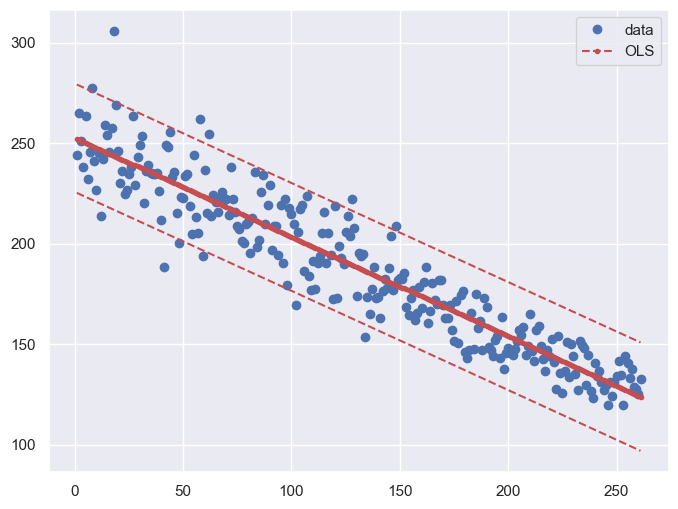

In [47]:
# Input
x = chegadas["dia"]
y = chegadas["arrival_time_diff"]
x = sm.add_constant(x)
# Regressão linear do tempo de chegadas
model       = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)


#plotagem
pred_ols = model.get_prediction()
print(pred_ols)
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x["dia"], y, "o", label="data")
ax.plot(x["dia"], model.fittedvalues, "r--.", label="OLS")
ax.plot(x["dia"], iv_u, "r--")
ax.plot(x["dia"], iv_l, "r--")
ax.legend(loc="best")

fig.show()

Temos que os valores p são menores que o nível de significância adotado, e, 

---

portanto, o modelo de regressão existe. O intervalo entre chegadas depende do dia trabalhado seguindo a expressão:
$$intervalos(t) = -0,4933 \cdot t + 252,6629$$
Em que $t$ é um dia útil trabalhado.

Entretanto, para os dias em que $t > 512$ o tempo de chegada das chamadas seria negativo, o que levanta questões sobre se este método de regressão é aplicável para modelar o tempo entre as chamadas.

In [48]:
# Input
ols_resid  = model.resid
 
resid_fit = sm.OLS(np.asarray(ols_resid)[1:], sm.add_constant(np.asarray(ols_resid)[:-1])).fit()
rho = resid_fit.params[1]
# Using toepliz matriz as of near neighbours have stronger correlation betweeen themselfs as for the rest
order = toeplitz(range(len(ols_resid))) #it should be as big as the resids from the OLS
sigma = rho ** order #assuring that the error strutcture is this, an autocorrelation

sigma = rho ** order

gls_model = sm.GLS(y, x, sigma=sigma)
gls_results = gls_model.fit()
print(gls_results.summary())

# Não há plotagem para este método na lib

                            GLS Regression Results                            
Dep. Variable:      arrival_time_diff   R-squared:                       0.873
Model:                            GLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     1783.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          3.97e-118
Time:                        19:02:00   Log-Likelihood:                -1050.0
No. Observations:                 261   AIC:                             2104.
Df Residuals:                     259   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        252.6538      1.765    143.107      0.0

As diferenças entre os modelos de GLS e OLS foram ínfimas e podem ser feitas as mesmas considerações.

***

$$intervalos(t) = -0,4933 \cdot t + 252,6538$$


### Outros tipos de regressão para os tempos de chegada

***
1. Regressão Exponencial
  1. Com Viés
  2. Sem Viés


                            OLS Regression Results                            
Dep. Variable:      arrival_time_diff   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     2141.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          3.27e-127
Time:                        19:02:00   Log-Likelihood:                 323.56
No. Observations:                 261   AIC:                            -643.1
Df Residuals:                     259   BIC:                            -636.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5643      0.009    637.398      0.0

C:\Users\Lucas\AppData\Local\Temp\ipykernel_10364\1475092570.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


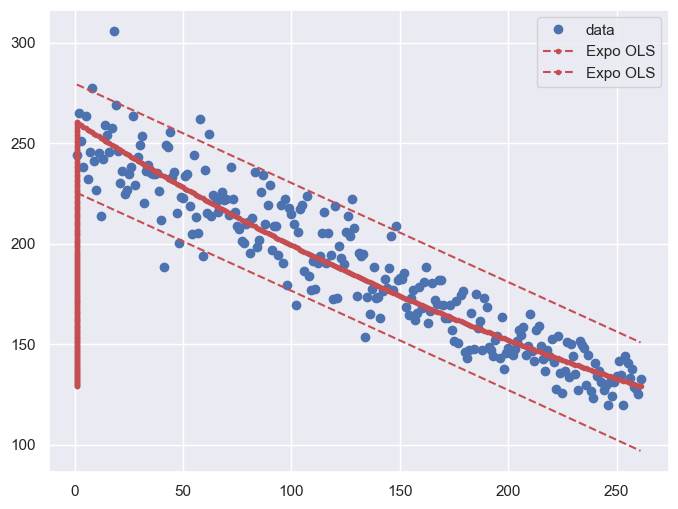

In [49]:
# Regressão exponencial
exp_model       = sm.OLS(np.log(y), x).fit()
exp_predictions = model.predict(x)
print_model = exp_model.summary()
print(print_model)
print(max(x["dia"]))


#plotagem
pred = 260.9424*np.exp(-0.0027*x["dia"])
pred_exp = model.get_prediction()
iv_l = pred_exp.summary_frame()["obs_ci_lower"]
iv_u = pred_exp.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x["dia"], y, "o", label="data")
ax.plot(x, pred, "r--.", label="Expo OLS")
ax.plot(x["dia"], iv_u, "r--")
ax.plot(x["dia"], iv_l, "r--")
ax.legend(loc="best")

fig.show()



Para Este caso, a explicabilidade do modelo aumentou e o problema que antes existia já não mais existe. Como os Valores P seguem menores do que 0, o modelo existe e pode ser usado.

***
No Modelo de regressão exponencial, temos:
$$intervalos(t) = 260,9424 \cdot e^{-0,0027x} $$

obs: $260,9424 = e^{5,5643}$


[-2.64799213e-03  5.56624179e+00]


C:\Users\Lucas\AppData\Local\Temp\ipykernel_10364\3299992797.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


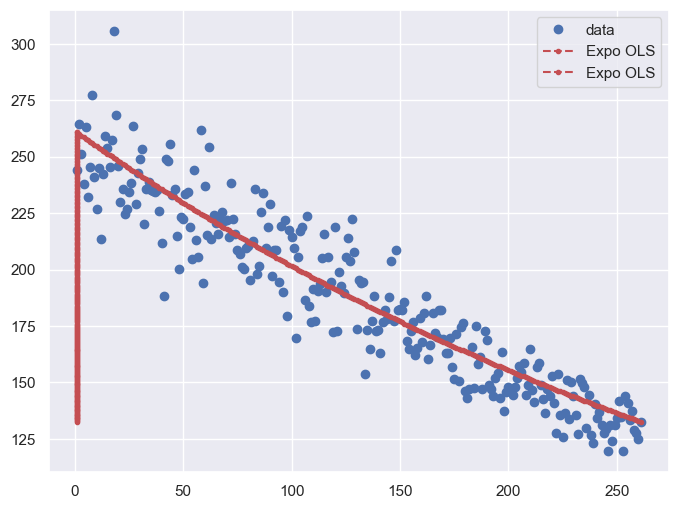

In [50]:
#Também podemos usar o numpy para fazer uma regressão sem "bias"
print(np.polyfit(x["dia"].values.flatten(), np.log(y.values.flatten()), 1, w = np.sqrt(y.values.flatten())))

#plotagem
pred = 261.4492*np.exp(-0.0026*x["dia"])
fig, ax = plt.subplots(figsize=(8, 6))
pred_exp = model.get_prediction()
#iv_l = pred_exp.summary_frame()["obs_ci_lower"]
#iv_u = pred_exp.summary_frame()["obs_ci_upper"]


ax.plot(x["dia"], y, "o", label="data")
ax.plot(x, pred, "r--.", label="Expo OLS")
#ax.plot(x["dia"], iv_u, "r--")
#ax.plot(x["dia"], iv_l, "r--")
ax.legend(loc="best")

fig.show()


Novamente, as diferenças foram ínfimas. A diferença é que este modelo não considera tanto peso para os valores pequenos da amostra.

*** 

$$intervalos(t) = 261.4492 \cdot e^{-0,0026x} $$
obs: $261.4492 = e^{5,5662}$
